# Aprendizaje Supervisado

## Bibliotecas

In [1]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
# lectura de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
# barras de progreso
from tqdm import tqdm

# directorio de datos
DATA_DIR = '../data'

# CIFAR-10
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)
LABELS = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# tamaño del lote
BATCH_SIZE = 128

#### Datos

#### Exploración

In [2]:
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)
# creamos un DataLoader
# dl = DataLoader(ds, batch_size=12)

Files already downloaded and verified


images[0] shape=(32, 32, 3) dtype=uint8
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7]
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse']


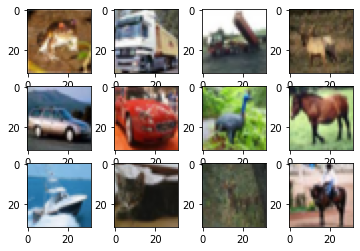

In [3]:
# cargamos algunas imagenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
print(labels)
print([LABELS[l] for l in labels])
io.imshow_collection(images)
io.show()

#### Cargadores de entrenamiento

In [4]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    trn_ds,
    batch_size=BATCH_SIZE,
    # tamaño del lote
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Cargadores de validación

In [5]:
# transformaciones para la imagen
val_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
val_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=val_tsfm
)

# creamos un DataLoader
val_dl = DataLoader(
    # subconjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE
)

# imprimimos forma y tipo del lote
for x, y in take(val_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


## Modelo

In [6]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.num_feats = 3 * 32 * 32
        self.fc1 = nn.Linear(self.num_feats, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, self.num_feats)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        # filtros en las capas conv
        C1 = 8
        # neuronas en las capas fc
        FC1 = 8 * 16 * 16
        # numero de características
        self.num_feats = FC1
        
        # capas conv
        self.cnn = nn.Sequential(
            
            # bloque conv1
            # [N, 3, 32, 32] => [N, 8, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=C1, kernel_size=3, padding=1),
            # [N, 8, 32, 32]
            nn.ReLU(),
            # [N, 8, 32, 32] => [N, 8, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 16, 16]
            nn.BatchNorm2d(C1),
            
        )
        
        # capas fc
        self.cls = nn.Sequential(
            # bloque fc1
            # [N, 8x16x16] => [N, 10]
            nn.Linear(FC1, 10)
        )

    def forward(self, x):
        # [N, 3, 32, 32] => [N, 8, 16, 16]
        x = self.cnn(x)
        # [N, 8, 16, 16] => [N, 8x16x16]
        x = x.view(-1, self.num_feats)
        # [N, 8x16x16] => [N, 10]
        x = self.cls(x)
        return x

## Entrenamiento

In [8]:
# creamos un modelo
model = CNN()
# función de pérdida
loss_fn = nn.CrossEntropyLoss()
# optimizador
opt = optim.Adam(model.parameters(), lr=0.001)

# ciclo de entrenamiento
EPOCHS = 5
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in val_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # imprimimos métricas
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        print(f'E {epoch} loss={loss:6.2f} acc={acc:.2f}')
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss=130.69 acc=54.19
E 1 loss=123.77 acc=56.29
E 2 loss=124.70 acc=56.36
E 3 loss=120.43 acc=58.31
E 4 loss=119.06 acc=58.18
